In [2]:
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.visualization.scatter import Scatter
from pymoo.core.algorithm import Algorithm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go

## Graphs and visualizations

In [3]:
def plot_comparison(solution: np.ndarray, problem: Problem, with_nsga2: bool = True) -> None:
    """Compare Pareto Fronts in a plot"""
    # Frente de Pareto original
    pareto_front = problem.pareto_front()

    if with_nsga2:  # Frente de Pareto de NSGA-II
        algorithm = NSGA2(pop_size=100)
        result = minimize(problem, algorithm, termination=('n_gen', 100), verbose=False)

    if problem.n_obj == 2:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(pareto_front[:, 0], pareto_front[:, 1], color='red', facecolor='none', marker='o', label="Original PF")
        if with_nsga2:
            ax.scatter(result.F[:, 0], result.F[:, 1], color='blue', marker='x', label="NSGA-II PF")
        ax.scatter(solution[:, 0], solution[:, 1], c='green', marker="*", label="Solution PF")
        ax.set_xlabel('f1')
        ax.set_ylabel('f2')
        ax.legend(loc='upper right')
        plt.show()
    else: # 3D
        fig = go.Figure()

        fig.add_trace(go.Scatter3d(
            x=pareto_front[:, 0], y=pareto_front[:, 1], z=pareto_front[:, 2],
            mode='markers',
            marker=dict(size=5, color='red'),
            name='Original PF'
        ))

        if with_nsga2:
            fig.add_trace(go.Scatter3d(
                x=result.F[:, 0], y=result.F[:, 1], z=result.F[:, 2],
                mode='markers',
                marker=dict(size=5, color='blue'),
                name='NSGA-II PF'
            ))

        fig.add_trace(go.Scatter3d(
            x=solution[:, 0], y=solution[:, 1], z=solution[:, 2],
            mode='markers',
            marker=dict(size=5, color='green'),
            name='Solution PF'
        ))

        fig.update_layout(
            scene=dict(
                xaxis=dict(title='f1', range=[0, 1.6], autorange=False),
                yaxis=dict(title='f2', range=[0, 1.6], autorange=False),
                aspectmode='cube'
            ),
            legend=dict(x=0, y=1),
            width=800,
            height=600
        )
        fig.show()

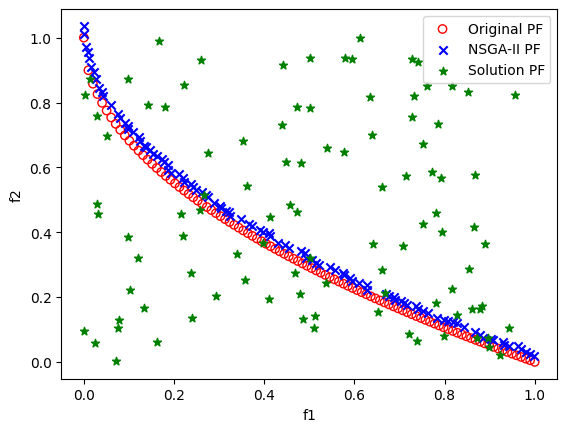

In [4]:
random_solution = np.random.rand(100, 2)
problem = get_problem("zdt1")
plot_comparison(random_solution, problem, with_nsga2=True)

In [5]:
def plot_pareto_front_animation(generations_data: list[np.ndarray], problem: Problem, save_path: str, interval=500):
    """Save GIF from the historical Pareto Front"""
    pareto_front = problem.pareto_front()
    algorithm = NSGA2(pop_size=100)
    result = minimize(problem, algorithm, termination=('n_gen', 100), verbose=False)

    fig = plt.figure()
    if problem.n_obj == 2:
        ax = fig.add_subplot(1,1,1)
    else:
        ax = fig.add_subplot(1,1,1, projection="3d")

    def update(frame):
        ax.clear()
        ax.set_title(f"Generation {frame + 1}")

        solution = generations_data[frame]
        if problem.n_obj == 2:
            ax.scatter(pareto_front[:, 0], pareto_front[:, 1], color='red', facecolor='none', marker='o', label="Original PF")
            ax.scatter(result.F[:, 0], result.F[:, 1], color='blue', marker='x', label="NSGA-II PF")
            ax.scatter(solution[:, 0], solution[:, 1], c='green', marker="*", label="Solution PF")
        else:
            ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], color='red', marker='o', label="Original PF")
            ax.scatter(result.F[:, 0], result.F[:, 1], result.F[:, 2], color='blue', marker='x', label="NSGA-II PF")
            ax.scatter(solution[:, 0], solution[:, 1], solution[:, 2], color='green', marker="*", label="Solution PF")
            ax.set_zlabel("f3")
            ax.set_zlim(min_bound, 6) # for mw14
        ax.legend(loc='upper right')

    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    min_bound, max_bound = problem.xl[0], problem.xu[0]
    ax.set_xlim(min_bound, max_bound)
    ax.set_ylim(min_bound, max_bound)

    ani = FuncAnimation(fig, update, frames=len(generations_data), interval=interval)
    ani.save(save_path, writer='pillow')
    print(f"Animation saved to {save_path}")

---

## Crossovers

In [7]:
def sbx_crossover(parent1, parent2, problem):
    """
    Apply crossover to a single pair of parents.

    Parameters:
        parent1 (np.ndarray): The first parent.
        parent2 (np.ndarray): The second parent.

    Returns:
        np.ndarray: The offspring pair after crossover.
    """
    eta = 15
    lower_bounds, upper_bounds = problem.bounds()

    u = np.random.rand(len(parent1))
    beta = np.where(u <= 0.5, (2 * u) ** (1 / (eta + 1)), (1 / (2 * (1 - u))) ** (1 / (eta + 1)))
    child1 = 0.5 * ((1 + beta) * parent1 + (1 - beta) * parent2)
    child2 = 0.5 * ((1 - beta) * parent1 + (1 + beta) * parent2)

    child1 = np.clip(child1, lower_bounds, upper_bounds)
    child2 = np.clip(child2, lower_bounds, upper_bounds)

    return child1, child2

## Mutations

In [8]:
def pm_mutate(individual, problem):
    """
    Perform polynomial mutation on an individual.

    Parameters:
        individual (np.ndarray): The individual to mutate.
        problem (Problem): The problem instance to get the bounds.

    Returns:
        np.ndarray: The mutated individual.
    """
    lower_bounds, upper_bounds = problem.bounds()
    mutated_individual = individual.copy()  # Make a copy to avoid modifying the original

    for j in range(len(individual)):  # Iterate over each gene in the individual
        # Polynomial mutation
        if np.random.rand() < 0.1:  # Mutation probability
            delta = np.random.uniform(-1, 1)  # This is an example mutation delta
            mutated_individual[j] += delta  # Apply mutation
            mutated_individual[j] = np.clip(mutated_individual[j], lower_bounds[j], upper_bounds[j])  # Clip to bounds

    return mutated_individual


## Selections

In [9]:
def tournament_by_rank_and_crowding(population, fitness, ranks, crowding_distances):
    # Randomly select two individuals for the tournament
    indices = np.random.choice(len(population), size=2, replace=True)
    individual1, individual2 = population[indices]
    fitness1, fitness2 = fitness[indices]

    # Extract additional properties for comparison
    rank1, cd1 = ranks[indices[0]], crowding_distances[indices[0]]
    rank2, cd2 = ranks[indices[1]], crowding_distances[indices[1]]

    if rank1 < rank2:
        return individual1
    elif rank2 < rank1:
        return individual2

    # If rank or domination didn't make a decision, compare by crowding distance
    return (
        individual1 if cd1 > cd2 else individual2 if cd2 > cd1 else (
            individual1 if np.random.rand() < 0.5 else individual2
        )
    )

## Algorithm

In [10]:
from pymoo.util.randomized_argsort import randomized_argsort
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.core.survival import Survival, split_by_feasibility
from pymoo.core.population import Population
class SoftMajoR:
    def __init__(self, problem: Problem, 
                 p_cross = 1, p_mut = 0.1, population_size=100, generations=100, 
                 crossover_method="sbx", mutation_method="pm", 
                 elitism = False,
                 selection_method="tournament_by_rank_and_crowding", selection_approach="full_population"):
        """
        Inicializa el algoritmo evolutivo.

        Parámetros:
            problem (Problem): Instancia de un problema de pymoo que define el problema de optimización 
                                multiobjetivo, con sus variables de decisión, restricciones y funciones objetivo.
            
            p_cross (float, opcional): Probabilidad de crossover (cruce) en el algoritmo evolutivo. 
                                        Este valor determina la probabilidad con la que se realizará un cruce 
                                        entre dos padres para generar descendencia. El valor predeterminado es 1, 
                                        lo que significa que siempre se intentará realizar un cruce cuando se 
                                        seleccionen dos padres. 
            
            p_mut (float, opcional): Probabilidad de mutación en el algoritmo evolutivo. 
                                      Este valor determina la probabilidad de aplicar una mutación a un descendiente. 
                                      El valor predeterminado es 0.1, lo que significa que hay un 10% de probabilidad 
                                      de mutación para cada descendiente.

            population_size (int, opcional): Tamaño de la población. Este parámetro controla cuántos individuos 
                                              estarán presentes en la población de cada generación. El valor 
                                              predeterminado es 100.

            generations (int, opcional): Número de generaciones. Especifica la cantidad de iteraciones o 
                                          ciclos que el algoritmo evolucionará. Cada generación implica la 
                                          selección, cruce, mutación y evaluación de individuos en la población. 
                                          El valor predeterminado es 100.

            crossover_method (str, opcional): Método de cruce a utilizar. Define la técnica de cruce utilizada 
                                               para generar la descendencia de dos padres. El valor predeterminado es 
                                               `"sbx"`, que corresponde al cruce basado en SBX (Simulated Binary Crossover).

            mutation_method (str, opcional): Método de mutación a utilizar. Define la técnica de mutación que 
                                              se aplicará a los descendientes. El valor predeterminado es `"pm"`, que 
                                              corresponde a una mutación basada en la probabilidad de mutación por 
                                              punto de variación.

            selection_method (str, opcional): Método de selección a utilizar. Determina cómo se eligen los padres 
                                              para la creación de la descendencia. El valor predeterminado es 
                                              `"tournament_by_rank_and_crowding"`, que corresponde a un torneo de 
                                              selección que toma en cuenta el rango y la distancia de aglomeración 
                                              de los individuos.

            selection_approach (str, opcional): Enfoque de selección a utilizar. Este parámetro especifica si la 
                                                 selección debe realizarse entre toda la población o solo entre los 
                                                 individuos en el frente de Pareto. Puede ser uno de los siguientes valores:
                                                 - `"full_population"`: La selección se realiza entre todos los 
                                                   individuos de la población.
                                                 - `"pareto_front"`: La selección se realiza únicamente entre los 
                                                   individuos que están en el frente de Pareto, es decir, aquellos 
                                                   que son no dominados por otros en términos de sus objetivos.

        """
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.selection_approach = selection_approach
        self.elitism = elitism

        self.generations_history = list()
        self.pareto_history = list()

        self.p_cross = p_cross
        self.p_mut = p_mut

        self.crossover_method = crossover_method
        self.mutation_method = mutation_method
        self.selection_method = selection_method

    def initialize_population(self):
        """
        Initialize the population randomly within the problem bounds.

        Returns:
            np.ndarray: The initial population.
        """
        lower_bounds, upper_bounds = self.problem.bounds()
        return np.random.uniform(lower_bounds, upper_bounds, (self.population_size, self.problem.n_var))

    def evaluate_population(self, population):
        """
        Evaluate the objective values for the given population.

        Parameters:
            population (np.ndarray): The population to evaluate.

        Returns:
            np.ndarray: The objective values of the population.
        """
        return self.problem.evaluate(population, return_values_of=['F','G','H'])
    
        
    def crossover(self, parent1, parent2):
        if(self.crossover_method == "sbx"):
            return sbx_crossover(parent1, parent2, self.problem)
        else:
            raise ValueError("Invalid crossover method")

    def evolve(self):
        """
        Run the evolutionary algorithm.

        Returns:
            np.ndarray: The final population.
            np.ndarray: The final objective values.
        """
        # Initialize population
        population = self.initialize_population()

        for generation in range(self.generations):
            # Evaluate the population
            population=self.survive(population)
            fitness,g,h = self.evaluate_population(population)

            

            self.generations_history.append(fitness)
            pareto_front, pareto_fitness = self.calculate_pareto_front(population, fitness)
            self.pareto_history.append(pareto_fitness)
            
            # Compute rank and crowding distance
            self._ranks = self.assign_rank(population, fitness)
            self._crowding_distances = self.assign_crowding_distance(population, fitness)

            new_population = list()

            if(self.elitism):
                # Add the pareto front to the new population
                new_population.extend(pareto_front)

            while(self.population_size > len(new_population)):
                # Perform selection
                parent1 = self.selection(population, fitness)
                parent2 = self.selection(population, fitness)

                offspring1, offspring2 = parent1, parent2

                if(random.random() < self.p_cross):
                    # Apply crossover
                    offspring1, offspring1 = self.crossover(parent1, parent2)

                if(random.random() < self.p_cross):
                    # Apply mutation to offspring1
                    offspring1 = self.mutate(offspring1)

                if(random.random() < self.p_cross):
                    # Apply mutation to offspring2
                    offspring2 = self.mutate(offspring2)

                # Add the individuals to the new population
                new_population.append(offspring1)
                new_population.append(offspring2)

            population = np.array(new_population)
            
        # Final evaluation
        final_fitness,g,h = self.evaluate_population(population)
        return population, final_fitness
    
    def selection(self, population, fitness):
        """
        Perform the selected selection method using the selected approach.

        Returns:
            np.ndarray: The selected individual.
        """
        if self.selection_approach == "pareto_front":
            selection_population, selection_fitness = self.calculate_pareto_front(population, fitness)
        else:
            selection_population, selection_fitness = population, fitness
        
        if self.selection_method == "tournament_by_rank_and_crowding":
            return tournament_by_rank_and_crowding(selection_population, selection_fitness, self._ranks, self._crowding_distances)
        else:
            raise ValueError("Invalid selection method")

    def assign_rank(self, population, fitness):
        """
        Assign non-dominated ranks to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of ranks for the population.
        """
        n = len(population)
        ranks = np.zeros(n, dtype=int)
        domination_count = np.zeros(n, dtype=int)
        dominated_solutions = [[] for _ in range(n)]
        fronts = [[]]

        # Calculate domination relationships
        for i in range(n):
            for j in range(n):
                if np.all(fitness[i] <= fitness[j]) and np.any(fitness[i] < fitness[j]):
                    dominated_solutions[i].append(j)
                elif np.all(fitness[j] <= fitness[i]) and np.any(fitness[j] < fitness[i]):
                    domination_count[i] += 1
            
            if domination_count[i] == 0:  # No one dominates this solution
                ranks[i] = 0
                fronts[0].append(i)
        
        # Generate the fronts
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        ranks[j] = current_front + 1
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
        
        return ranks
    
    def assign_crowding_distance(self, population, fitness):
        """
        Assign crowding distance to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of crowding distances for the population.
        """
        n, num_objectives = fitness.shape
        distances = np.zeros(n)
        
        for m in range(num_objectives):
            sorted_indices = np.argsort(fitness[:, m])
            min_value = fitness[sorted_indices[0], m]
            max_value = fitness[sorted_indices[-1], m]
            distances[sorted_indices[0]] = distances[sorted_indices[-1]] = np.inf
            
            if max_value > min_value:  # Avoid division by zero
                for i in range(1, n - 1):
                    distances[sorted_indices[i]] += (
                        (fitness[sorted_indices[i + 1], m] - fitness[sorted_indices[i - 1], m]) /
                        (max_value - min_value)
                    )
        
        return distances

    def mutate(self, population):
        if(self.mutation_method == "pm"):
            return pm_mutate(population, self.problem)
        else:
            raise ValueError("Invalid mutation method")
        
    def calculate_pareto_front(self, population, fitness):
        """
        Calculate the Pareto front for the given population.

        Parameters:
            population (np.ndarray): The population.
            fitness (np.ndarray): The objective values of the population.

        Returns:
            np.ndarray: The Pareto-optimal solutions.
            np.ndarray: The corresponding objective values of the Pareto front.
        """
        is_pareto = np.ones(fitness.shape[0], dtype=bool)
        for i, f1 in enumerate(fitness):
            if is_pareto[i]:
                is_pareto[is_pareto] = np.any(fitness[is_pareto] < f1, axis=1)
                is_pareto[i] = True
        return population[is_pareto], fitness[is_pareto]
    def survive(self,pop,*args,**kwargs):
        n_survive = min(0, len(pop))
        F,G,H=self.evaluate_population(pop)
        CV=[]
        tol=1e-6
        if len(G[0])==2:
                boolean=True
        else:
            boolean=False
        for idx in range(len(pop)):
            vio=True
            if G[idx][0]<0:
                vio=False
            if boolean:
                if G[idx][1]>0:
                    vio=False
            CV.append(vio)
    
            
        # feasible_inequalities = np.all(G <= 0, axis=1)  # Inequality constraints satisfied
        # feasible_equalities = np.all(np.abs(H) <= tol, axis=1)  # Equality constraints satisfied

        # # Combine feasibility
        # b = feasible_inequalities & feasible_equalities 

        # feasible = np.where(b)[0]
        # infeasible = np.where(~b)[0]
        CV=np.array(CV)

        # print(CV)


        # infeasible = infeasible[np.argsort(CV[infeasible, 0])]

        return pop[CV]
    

## Problems

### MW7

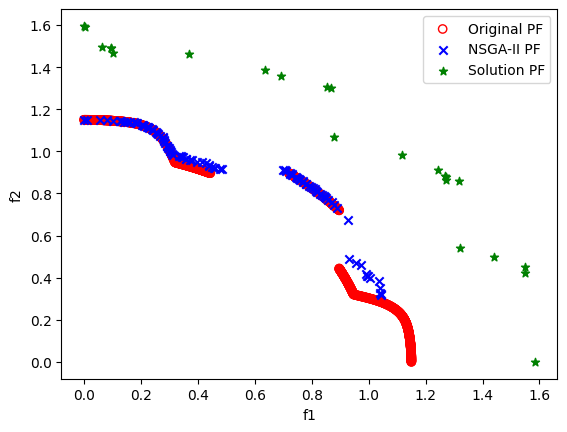

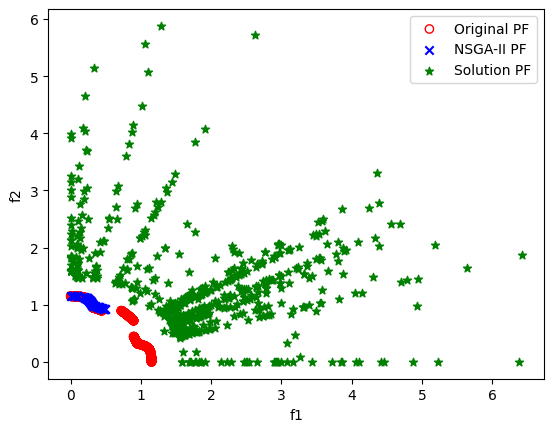

Animation saved to pareto_front.gif


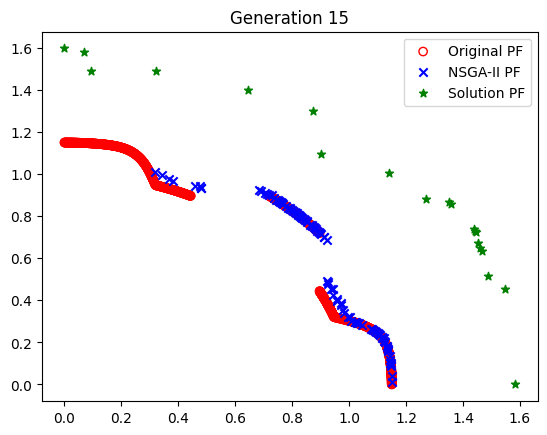

In [12]:
# Load a test problem from pymoo
problem = get_problem("mw7",n_var=30)

# Create and run the evolutionary algorithm
ea = SoftMajoR(problem, p_cross=0.9, p_mut=0.35, population_size=666, generations=15, 
              crossover_method="sbx", mutation_method="pm", selection_method="tournament_by_rank_and_crowding",
              elitism=True,
              selection_approach="pareto_front")
final_population, final_fitness = ea.evolve()

# Calculate Pareto front from the evolutionary algorithm results
pareto_population, pareto_fitness = ea.calculate_pareto_front(final_population, final_fitness)

# Plot the results
plot_comparison(pareto_fitness, problem, with_nsga2=True)
plot_comparison(final_fitness, problem, with_nsga2=True)

plot_pareto_front_animation(ea.pareto_history, problem, save_path="pareto_front.gif") 

### MW14

Animation saved to pareto_front.gif


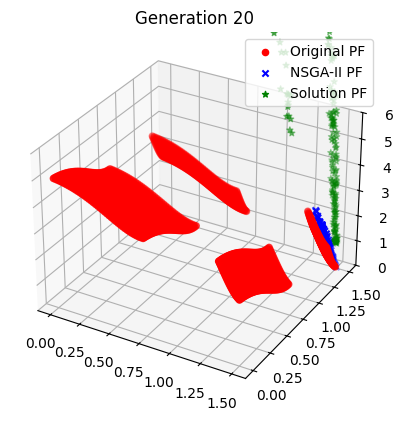

In [11]:
# Load a test problem from pymoo
problem = get_problem("mw14",n_var=30,)

# Create and run the evolutionary algorithm
ea = SoftMajoR(problem, p_cross=0.9, p_mut=0.35, population_size=500, generations=20, 
              crossover_method="sbx", mutation_method="pm", selection_method="tournament_by_rank_and_crowding",
              elitism=True,
              selection_approach="pareto_front")
final_population, final_fitness = ea.evolve()

# Calculate Pareto front from the evolutionary algorithm results
pareto_population, pareto_fitness = ea.calculate_pareto_front(final_population, final_fitness)

# Plot the results
plot_comparison(pareto_fitness, problem, with_nsga2=True)
plot_comparison(final_fitness, problem, with_nsga2=True)

plot_pareto_front_animation(ea.pareto_history, problem, save_path="pareto_front.gif") 